# Predicting the Likelihood of Heart Disease within a Patient

## Introduction
Heart disease is a term used to describe a range of conditions that affect the heart, including coronary artery disease, heart failure, and arrhythmias. It is a leading cause of death worldwide, and risk factors for heart disease include high blood pressure, high cholesterol levels, smoking, diabetes, and obesity. Early diagnosis of heart disease is essential for successful treatment and management of the condition.

The question that this project aimed to answer is: Can machine learning algorithms accurately predict the presence of heart disease in patients?

To answer this question, a dataset known as the Cleveland Heart Disease dataset was used. The dataset contains 303 instances, and each instance has 14 attributes, including age, sex, chest pain type, resting blood pressure, serum cholesterol levels, fasting blood sugar, electrocardiographic results, maximum heart rate achieved, exercise-induced angina, ST depression induced by exercise relative to rest, slope of the peak exercise ST segment, number of major vessels, thalassemia, and the presence of heart disease. The dataset was sourced from the UCI Machine Learning Repository and has been widely used for research purposes in the field of heart disease diagnosis.

## Methods & Results


1. In order to classify each new observation using a K-nearest neighbour classifier, we have to first calculate the distance between the new observation and each observation in the training set, sort the data table in ascending order according to the distances, choose the top K rows of the sorted table, then classify the new observation based on a majority vote of the neighbour classes.


2. The first step in the analysis was to download the file from the online database into Jupyter, then create a training and testing dataset. Once downloaded, the table headers were changed into a more readable format and only the columns of interest (Age, Sex, Heart_Disease, Maximum_Heart_Rate) were selected **(Tables 1 and 2)**.


3. Next, we will create the initial KNN model by making a model specification for K-nearest neighbours classification by calling the `nearest_neighbor()` function.  Here we specified that we want to use K= tune() neighbours because we are unsure which K value gives us the best accuracy for now. The `weight_func` argument controls how neighbours vote when classifying a new observation and we set it to "rectangular" in order to measure the straight-line distance.


4. Next, we will create the centering / scaling recipe. This is done in order to prevent having varying scales of each variable and an imbalance of class scales which are common problems of using KNN classification. A recipe allows us to standardize the data by having our variables in the data set have a mean (center) of 0 and a standard deviation (scale) of 1 and rebalance the data by oversampling the class that is less common (patients with heart disease).


5. The `vfold_cv` function was then used in order to split our training data into their respective v folds. The strata argument would be set to the categorical variable(s) in order to assure that the training and validations subsets would contain accurate proportions of each category of observation. We are trying to predict a heart disease diagnosis and mispredictions would lead to severe consequences. If a patient is misdiagnosed with a heart disease that they do not have, they may be subjected to unnecessary and potentially harmful treatments. On the other hand, if a patient is misdiagnosed as not having a heart condition when they do, this can delay necessary treatment and potentially lead to serious complications or even death.

6. We will create a `workflow()` object and add the initial model specification as well as the recipe to it, tuning it with the `tune_resamples()` function over the vfold_cv objects using the values in the vector k_grid. From there, the results and accuracies of the tuning are grabbed with the `collect_metrics()` function into the results object **(Table 3)**.


7. We will now pick the K value that will yield the highest accuracy estimate after visualizing the accuracies from the workflow() object. We can also get the optimal number of neighbours by sorting by accuracy in the results object into descending order and slicing the top value **(Table 3)**.


8. Once the best K value is decided, we will recreate the model specification with that K value, as well as the workflow() object to fit on the training data with the new model specification. 


9. Then we can predict with the new model on the testing data to evaluate our final accuracy with the predict() function combined with both conf_mat() and metrics() **(Tables 4 and 5)**.






In [22]:
#loading all packages
library(tidymodels)
library(tidyverse)
library(repr)
library(rvest)
library(readxl)
library(RColorBrewer)
library(cowplot)

In [23]:
# Read the csv file from UCI
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data_raw <- read_csv(url, col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [24]:
# Here we are cleaning and wrangling data and added meaningful column names. We changed the orignal attribute name "num" to "Heart_Disease" because "num" had little meaning.
set.seed(1)
heart_data <- rename(heart_data_raw,
                     Age = X1,
                     Sex = X2,
                     Chest_Pain_Type = X3,
                     Resting_Blood_Pressure = X4,
                     Total_Cholesterol = X5,
                     Fasting_Blood_Sugar = X6,
                     Resting_Electrocardiographic_Results = X7,
                     Maximum_Heart_Rate = X8,
                     Exercise_Induced_Angina = X9,
                     ST_Depression = X10,
                     Slope_Peak_excercise = X11,
                     Major_Vessels = X12,
                     Thalassemia = X13,
                     Heart_Disease = X14)

In [25]:
# We are predicting if the patient has heart disease so we want to change it into a factor.

heart_data$Heart_Disease <- as.factor(heart_data$Heart_Disease)

In [26]:
# We only want to know if each patient is tested positive or negative for heart disease.
# This means we only need the numbers 0 (negative) and 1 (postive) and want to remove other numbers.
# We reassigned the numbers 2, 3, and 4 to 1 because numbers that are greater 1 also mean that the patient has heart disease.

heart_data$Heart_Disease[heart_data$Heart_Disease== "4"]<- "1"
heart_data$Heart_Disease[heart_data$Heart_Disease== "3"]<- "1"
heart_data$Heart_Disease[heart_data$Heart_Disease== "2"]<- "1"


In [55]:
# Here we summarized the data in one table.
print("Summary Table for Heart Data")
summary_table <- heart_data |> 
                   group_by(Heart_Disease) |>
                   summarize(number_patients = n(),
                           mean_age = mean(Age, na.rm = TRUE),   
                           median_age = median(Age, na.rm = TRUE),
                           mean_resting_blood_pressure = mean(Resting_Blood_Pressure, na.rm = TRUE),
                           median_resting_blood_pressure = median(Resting_Blood_Pressure, na.rm = TRUE),  
                           mean_max_heart_rate = mean(Maximum_Heart_Rate, na.rm = TRUE),
                           median_max_heart_rate = median(Maximum_Heart_Rate, na.rm = TRUE),
                           number_rows_missing_data = sum(heart_data=="?"))
summary_table


[1] "Summary Table for Heart Data"


Heart_Disease,number_patients,mean_age,median_age,mean_resting_blood_pressure,median_resting_blood_pressure,mean_max_heart_rate,median_max_heart_rate,number_rows_missing_data
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,164,52.58537,52,129.2500,130,158.378,161,6
1,139,56.62590,58,134.5683,130,139.259,142,6


In [56]:
# We separate the data into training and testing data.
set.seed(1)

heart_cut <- heart_data |> select(Age, Sex, Heart_Disease, Maximum_Heart_Rate)
heart_split <- initial_split(heart_cut, prop = 0.75, strata = Heart_Disease) 
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

heart_split_all_variables <- initial_split(heart_data, prop = 0.75, strata = Heart_Disease) 
heart_train_all_variables <- training(heart_split_all_variables)   
heart_test_all_variables <- testing(heart_split_all_variables)   


#### Table Legend
Table 1: Training Data<br>
Table 2: Testing Data<br>
Table 3: KNN Classification Accuracies to find Optimal K Value <br>
Table 4: Confusion Matrix of Classifier <br>
Table 5: Prediction Accuracy of Classifier

#### Figure Legend
Figure 1: Exploratory Scatterplot of Good Predictor Variable (Age and Maximum Heart Rate) <br>
Figure 2: Exploratory Scatterplot of Good Predictor Variable (Age and Sex)<br>
Figure 3: Exploratory Scatterplot of Bad Predictor Variable (Cholesterol) <br>
Figure 4: Exploratory Scatterplot of Bad Predictor Variable (Resting Blood Pressure)<br>
Figure 5: Accuracy Plot to Find Optimal K Value

#### Table 1: Training Data

In [52]:
print("Training Data with Selected Columns")
head(heart_train)

[1] "Training Data with Selected Columns"


Age,Sex,Heart_Disease,Maximum_Heart_Rate
<dbl>,<dbl>,<fct>,<dbl>
63,1,0,150
37,1,0,187
41,0,0,172
57,1,0,148
56,0,0,153
57,1,0,174


#### Table 2: Testing Data

In [53]:
print("Testing Data with Selected Columns")
head(heart_test)

[1] "Testing Data with Selected Columns"


Age,Sex,Heart_Disease,Maximum_Heart_Rate
<dbl>,<dbl>,<fct>,<dbl>
56,1,0,178
62,0,1,160
57,0,0,163
44,1,0,173
52,1,0,162
54,1,0,160


#### KNN Classification Setup

In [31]:
heart_initial_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [32]:
heart_recipe <- recipe(Heart_Disease ~ Age + Sex + Maximum_Heart_Rate, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [33]:
heart_vfold <- vfold_cv(heart_train, v = 5, strata = Heart_Disease)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

#### Table 3: KNN Classification Accuracies to find Optimal K Value

In [48]:
heart_results <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_initial_spec) |>
       tune_grid(resamples = heart_vfold, grid = k_vals) |>
       collect_metrics()

print("Accuracy Values for Each K Value")

accuracies <- heart_results |>
  filter(.metric == "accuracy") 
accuracies



! Fold1: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.



[1] "Accuracy Values for Each K Value"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6164383,5,0.039950076,Preprocessor1_Model01
6,accuracy,multiclass,0.6825384,5,0.043782698,Preprocessor1_Model02
11,accuracy,multiclass,0.6822442,5,0.024512376,Preprocessor1_Model03
16,accuracy,multiclass,0.7134651,5,0.020073336,Preprocessor1_Model04
21,accuracy,multiclass,0.7400439,5,0.014468821,Preprocessor1_Model05
26,accuracy,multiclass,0.7268072,5,0.026335794,Preprocessor1_Model06
31,accuracy,multiclass,0.7180149,5,0.018777317,Preprocessor1_Model07
36,accuracy,multiclass,0.7311550,5,0.019005143,Preprocessor1_Model08
41,accuracy,multiclass,0.7226570,5,0.013783448,Preprocessor1_Model09


In [44]:
# the number of optimal neighbours is 46
optimal_neighbours <- accuracies |> arrange(desc(mean)) |> select(neighbors) |> slice(1) 
optimal_neighbours

neighbors
<dbl>
46


#### Table 4: Confusion Matrix of Classifier

In [49]:
set.seed(1)

heart_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_neighbours) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_final_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart_final_spec) |>
       fit(data = heart_train)

heart_testing <- predict(heart_final_fit, heart_test) |> bind_cols(heart_test)

print("Confusion Matrix of Classifier")
predictions <- heart_testing |> conf_mat(truth = Heart_Disease, estimate = .pred_class)

predictions


[1] "Confusion Matrix of Classifier"


          Truth
Prediction  0  1  2  3  4
         0 33 15  0  0  0
         1  8 20  0  0  0
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

#### Table 5: Prediction Accuracy of Classifier 

In [50]:
set.seed(1)
print("Prediction Accuracy of Classifier")

prediction_accuracy <- heart_testing |> metrics(truth = Heart_Disease, estimate = .pred_class)

prediction_accuracy

[1] "Prediction Accuracy of Classifier"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6973684
kap,multiclass,0.3818953


#### Figure 1: Exploratory Scatterplots of Good Predictor Variable (Age and Maximum Heart Rate)

Age and maximum heart rate are good predictors because 

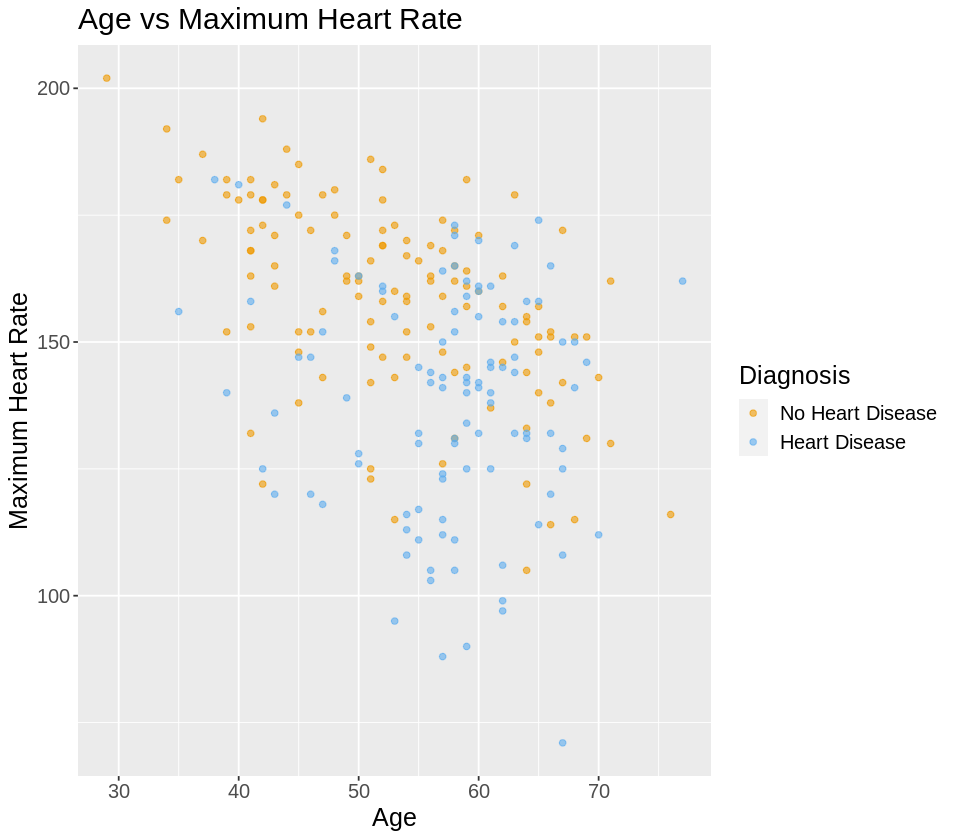

In [43]:
options(repr.plot.width = 8, repr.plot.height = 7)

age_vs_HeartRate <- heart_train |>
    ggplot(aes(x = Age, y = Maximum_Heart_Rate, colour = Heart_Disease)) +
    geom_point(alpha = 0.6) +
    xlab("Age") +
    ylab("Maximum Heart Rate") +
    ggtitle("Age vs Maximum Heart Rate") +
    labs(color = "Diagnosis") +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("orange2", "steelblue2")) +
    theme(text = element_text(size = 15))
age_vs_HeartRate


#### Figure 2: Exploratory Scatterplots of Good Predictor Variable (Age and Sex)

Age and sex and good predictor variables because there is a clear separation between the distributions of the two classes with little overlap and different median values. This shows that instances from both classes will be easily distinguishable.

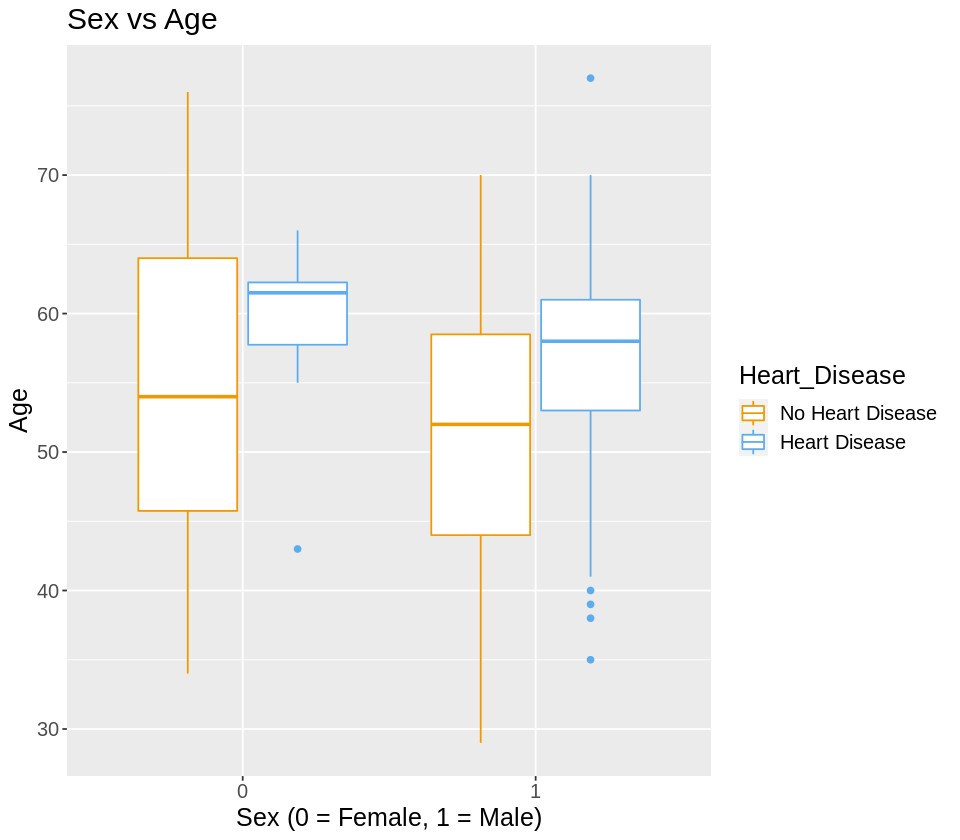

In [42]:
options(repr.plot.width = 8, repr.plot.height = 7)

age_vs_sex <- ggplot(heart_train, aes(x = as_factor(Sex), y = Age, color = Heart_Disease)) +
  geom_boxplot() +
  labs(x = "Sex (0 = Female, 1 = Male)", y = "Age",  fill = "Type") +
   ggtitle("Sex vs Age") +
  scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("orange2", "steelblue2")) +
    theme(text = element_text(size = 15))

age_vs_sex

#### Figure 3: Exploratory Scatterplots of Bad Predictor Variable (Cholesterol)

Cholesterol is a bad variable because there is a large overlap between the two classes. This makes it difficult for KNN classification to assign instances to the correct class since instances from both classes are very likely to be among the k-nearest neighbors of a given instance.

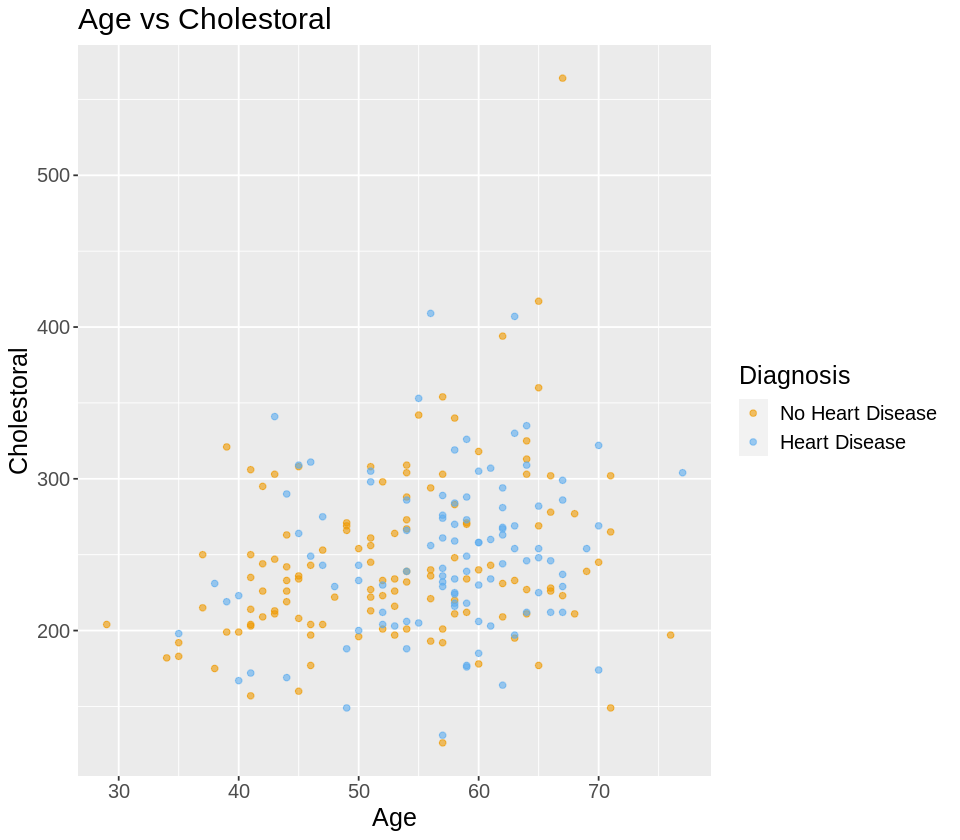

In [40]:
options(repr.plot.width = 8, repr.plot.height = 7)

age_vs_cholesterol <- heart_train_all_variables |>
    ggplot(aes(x = Age, y = Total_Cholesterol, colour = Heart_Disease)) +
    geom_point(alpha = 0.6) +
    xlab("Age") +
    ylab("Cholestoral") +
    ggtitle("Age vs Cholestoral") +
    labs(color = "Diagnosis") +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("orange2", "steelblue2")) +
    theme(text = element_text(size = 15))
age_vs_cholesterol


#### Figure 4: Exploratory Scatterplot of Bad Predictor Variable (Resting Blood Pressure)

Resting blood pressure is a bad variable because there is a large overlap between the two classes. This makes it difficult for KNN classification to assign instances to the correct class since instances from both classes are very likely to be among the k-nearest neighbors of a given instance.

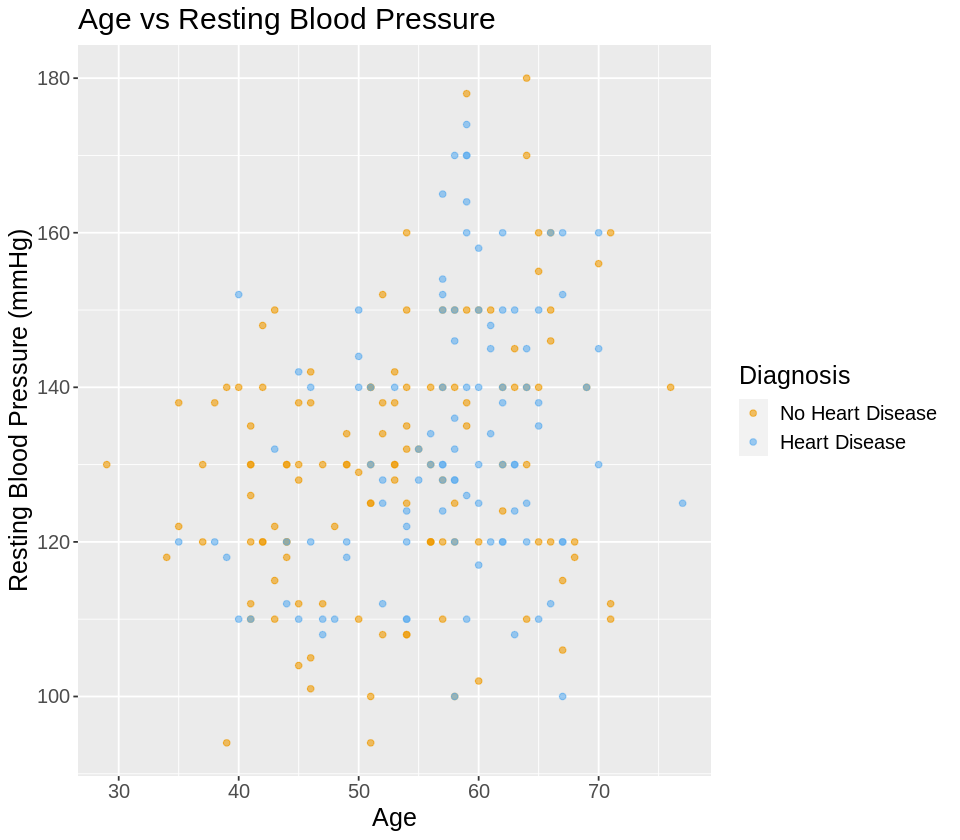

In [39]:
options(repr.plot.width = 8, repr.plot.height = 7)


age_vs_resting_blood_pressure <- heart_train_all_variables |>
    ggplot(aes(x = Age, y = Resting_Blood_Pressure, colour = Heart_Disease)) +
    geom_point(alpha = 0.6) +
    xlab("Age") +
    ylab("Resting Blood Pressure (mmHg)") +
    ggtitle("Age vs Resting Blood Pressure") +
    labs(color = "Diagnosis") +
    scale_color_manual(labels = c("No Heart Disease", "Heart Disease"), values = c("orange2", "steelblue2"))+
    theme(text = element_text(size = 15))

age_vs_resting_blood_pressure

#### Figure 5: Accuracy Plot to Find Optimal K Value

The optimal K value would be the value with the highest accuracy estimate which is 46.

accuracy_plot <- ggplot(accuracies, aes(y = mean, x = neighbors)) + geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Neighbors vs Accuracy Estimate") +
    theme(text = element_text(size = 15))

accuracy_plot

## Discussion

#### Findings
- In conclusion, our KNN calculations and final predictions were able to conclude the resulting predictions with an accuracy of diagnosing a patient with 69.7% based on a patient's age, sex, and maximum heart rate.
- We did expect to have a fairly high rate of accuracy regarding our predictions based on our predictor variables. We found the predictor variables resulted in a fairly good distinction between groups that were diagnosed with and without heart disease; however, there was always a small portion of overlap within our predictor variable visualizations, so it was certain that the accuracy of our predictions would not result in completely accurate predictions.


#### Impact of Findings
- We were able to make a code that would use three predictor variables to help diagnose patients with heart disease with a 69.7% accuracy. While this test is certainly not a determining diagnosis, it can certainly help diagnose the majority of at-risk patients that should be tested for heart disease. 
- This model could potentially assist in discovering if patients, based upon their predictor variables, should seek professional consultation regarding their degree of risk for heart disease in its multiple forms. With more alterations to the code and the addition of better predictor variables, this model could serve as an invaluable tool for diagnosing a patient without outright symptoms. 
- Over two-thirds of people who suffer from heart attacks not due to a blood clot, are likely to go undiagnosed by a medical professional (Williamson, 2022).
- With the help and perfection of this model, many people will be able to verify if they are at risk.

#### Future Areas of Investigation
- What variables within the data set could be used in order to maximize prediction accuracy regarding heart disease diagnoses?
- What could be done differently within our model in order to yield a higher prediction accuracy?
- How can the perfection of this model help average citizens without any symptoms of heart disease?


## References


1. Williamson, Laura. “Undiagnosed Heart Disease May Be Common in People with Heart Attacks Not Caused by Clots.” Www.heart.org, 24 Jan. 2023, https://www.heart.org/en/news/2022/03/28/undiagnosed-heart-disease-may-be-common-in-people-with-heart-attacks-not-caused-by-clots#:~:text=March%2028%2C%202022-,Undiagnosed%20heart%20disease%20may%20be%20common%20in%20people,attacks%20not%20caused%20by%20clots&amp;text=More%20than%20two%2Dthirds%20of,a%20small%20study%20from%20Scotland. 
2.